Group Members:

1.   Mirza Taha Hassan    Cs-21018
2.   Shayan Zahid         Cs-21026
3.   Ibrahim Nazir        Cs-21037
4.   Muhammad Abdurrahman Cs-21107

###Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from collections import Counter

###Self Built Models

In [3]:
#Self Random Forest Algorithm
class RandomForestScratch:
    def __init__(self, n_estimators=100, max_depth=None, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_estimators):
            print(f"Training tree {i + 1}/{self.n_estimators}")
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features)
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            print(f"Tree {i + 1} trained")


    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        return np.squeeze(np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_preds))

In [4]:
#Self Decision Tree Algorithm
class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or num_classes == 1:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}

        best_split = None
        best_gain = 0.0

        # Calculate the entropy (or Gini impurity) of the current node
        current_entropy = self._entropy(y)

        # Iterate over each feature to find the best split
        for feature_idx in range(num_features):
            feature_values = np.unique(X[:, feature_idx])

            if len(feature_values) > 10:  # Assuming a feature is continuous if it has more than 10 unique values
                # Continuous feature: Use Reduction of Variance to find the best split point
                sorted_idx = np.argsort(X[:, feature_idx])
                for i in range(1, len(sorted_idx)):
                    if X[sorted_idx[i], feature_idx] != X[sorted_idx[i - 1], feature_idx]:
                        split_value = (X[sorted_idx[i], feature_idx] + X[sorted_idx[i - 1], feature_idx]) / 2.0
                        X_left, y_left, X_right, y_right = self._split_continuous(X, y, feature_idx, split_value)
                        gain = self._variance_reduction(y, y_left, y_right)
                        if gain > best_gain:
                            best_gain = gain
                            best_split = {'feature_idx': feature_idx, 'split_value': split_value,
                                          'X_left': X_left, 'y_left': y_left,
                                          'X_right': X_right, 'y_right': y_right}
            else:
                # Categorical feature: Use Information Gain to find the best split
                for value in feature_values:
                    X_subset, y_subset = self._split_categorical(X, y, feature_idx, value)
                    gain = self._information_gain(current_entropy, [y_subset, y[~(X[:, feature_idx] == value)]])
                    if gain > best_gain:
                        best_gain = gain
                        best_split = {'feature_idx': feature_idx, 'value': value,
                                      'X_subset': X_subset, 'y_subset': y_subset}

        if best_split is None:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}

        if 'split_value' in best_split:
            # Continuous split
            left_subtree = self._grow_tree(best_split['X_left'], best_split['y_left'], depth + 1)
            right_subtree = self._grow_tree(best_split['X_right'], best_split['y_right'], depth + 1)
            return {'leaf': False, 'feature_idx': best_split['feature_idx'],
                    'split_value': best_split['split_value'],
                    'left': left_subtree, 'right': right_subtree}
        else:
            # Categorical split
            remaining_X = X[~(X[:, best_split['feature_idx']] == best_split['value'])]
            remaining_y = y[~(X[:, best_split['feature_idx']] == best_split['value'])]
            subset_tree = self._grow_tree(best_split['X_subset'], best_split['y_subset'], depth + 1)
            remaining_tree = self._grow_tree(remaining_X, remaining_y, depth + 1)
            return {'leaf': False, 'feature_idx': best_split['feature_idx'], 'value': best_split['value'],
                    'subset': subset_tree, 'remaining': remaining_tree}

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _information_gain(self, parent_entropy, subsets):
        total = sum(len(subset) for subset in subsets)
        gain = parent_entropy - sum((len(subset) / total) * self._entropy(subset) for subset in subsets)
        return gain

    def _split_categorical(self, X, y, feature_idx, value):
        mask = X[:, feature_idx] == value
        return X[mask], y[mask]

    def _variance_reduction(self, parent, left, right):
        total_var = np.var(parent)
        left_var = np.var(left) if len(left) > 0 else 0
        right_var = np.var(right) if len(right) > 0 else 0
        total_size = len(left) + len(right)
        reduction = total_var - ((len(left) / total_size) * left_var + (len(right) / total_size) * right_var)
        return reduction

    def _split_continuous(self, X, y, feature_idx, split_value):
        mask_left = X[:, feature_idx] <= split_value
        mask_right = X[:, feature_idx] > split_value
        return X[mask_left], y[mask_left], X[mask_right], y[mask_right]

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, node):
        if node['leaf']:
            return node['class']
        else:
            if 'split_value' in node:
                # Continuous split
                if x[node['feature_idx']] <= node['split_value']:
                    return self._predict_tree(x, node['left'])
                else:
                    return self._predict_tree(x, node['right'])
            else:
                # Categorical split
                if x[node['feature_idx']] == node['value']:
                    return self._predict_tree(x, node['subset'])
                else:
                    return self._predict_tree(x, node['remaining'])  # Follow the remaining tree

In [6]:
#self logistic regression
class Logistic_Regression_scratch:
    def __init__(self, learning_rate=0.1, n_iters=2000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
      x = np.clip(x, -500, 500)
      return 1 / (1 + np.exp(-x))

In [8]:
#self K-Nearest Neighbors
class KNNScratchNew:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        """Fit the kNN model to the training data."""
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """Predict the class labels for the test data."""
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        """Predict the class label for a single data point."""
        # Compute distances between x and all examples in the training set
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        # Get the k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Majority vote, most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _euclidean_distance(self, x1, x2):
        """Compute the Euclidean distance between two data points."""
        return np.sqrt(np.sum((x1 - x2) ** 2))

###Connect to Kaggle

In [9]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kagglee.json ~/.kaggle/
!chmod 600 ~/.kaggle/kagglee.json

#Data Collection:

**Import dataset from kaggle**

Dataset URL: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

In [10]:
!kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data
!unzip fraudulent-transactions-data.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data
License(s): CC0-1.0
100% 177M/178M [00:02<00:00, 61.5MB/s]
100% 178M/178M [00:02<00:00, 66.2MB/s]
Archive:  fraudulent-transactions-data.zip
  inflating: /content/Fraud.csv      


**Load dataset**

In [11]:
data =  pd.read_csv('/content/Fraud.csv')

**Check first five rows**

In [12]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Shape of dataset**

In [13]:
data.shape
print('Number of rows:', data.shape[0])
print('Number of columns:', data.shape[1])

Number of rows: 6362620
Number of columns: 11


**Dataset information**

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


**Basic data statistics**

In [15]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


#Data Preprocessing:

**Null values count**

In [16]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**Check duplicates**

In [17]:
data.duplicated().sum()

0

**Exploring transaction type**

In [18]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of legit & fraudulent transaction')

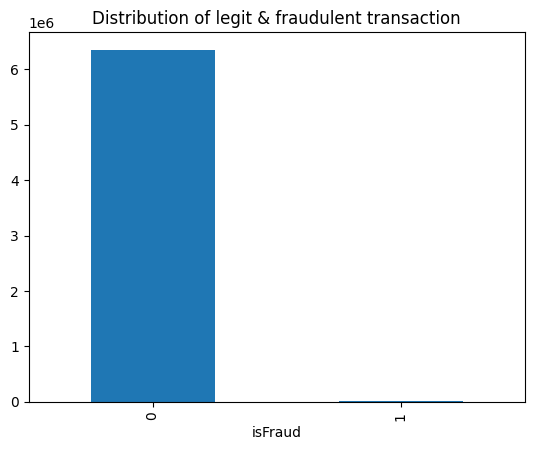

In [19]:
data['isFraud'].value_counts().plot(kind='bar').set_title('Distribution of legit & fraudulent transaction')

Dataset is highly unbalanced

*   0: Legit Transaction
*   1: Fraud Transaction



In [20]:
legit = data[data.isFraud == 0]
fraud = data[data.isFraud == 1]

In [21]:
legit.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

**Distribution of legit & fraudulent transaction**

In [22]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

**Compare values of legit & fraud transaction**

In [23]:
# data.groupby('isFraud').mean()

In [24]:
numerical_features = [i for i in data.columns if data[i].dtype == 'int64'or data[i].dtype =='int32' or data[i].dtype =='float64']
categorical_features = [i for i in data.columns if data[i].dtype == 'object']

**Numerical Features**

In [25]:
numerical_features

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

**Categorical Features**

In [26]:
categorical_features

['type', 'nameOrig', 'nameDest']

**Encode categorical features**

In [27]:
le = LabelEncoder()
for categorical_feature in categorical_features:
  data[categorical_feature] = le.fit_transform(data[categorical_feature])
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


#Explporatory Data Analysis (EDA):

**Transaction Type Distribution**

In [28]:
data.type.value_counts()

type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64

In [29]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(data,
             values=quantity,
             names=transactions,hole = 0.5,
             title="Distribution of Transaction Type")
figure.show()

* 0: CASH_IN  
* 1: CASH_OUT   
* 2: DEBIT      
* 3: PAYMENT  
* 4: TRANSFER    




**Numerical Features Distribution**

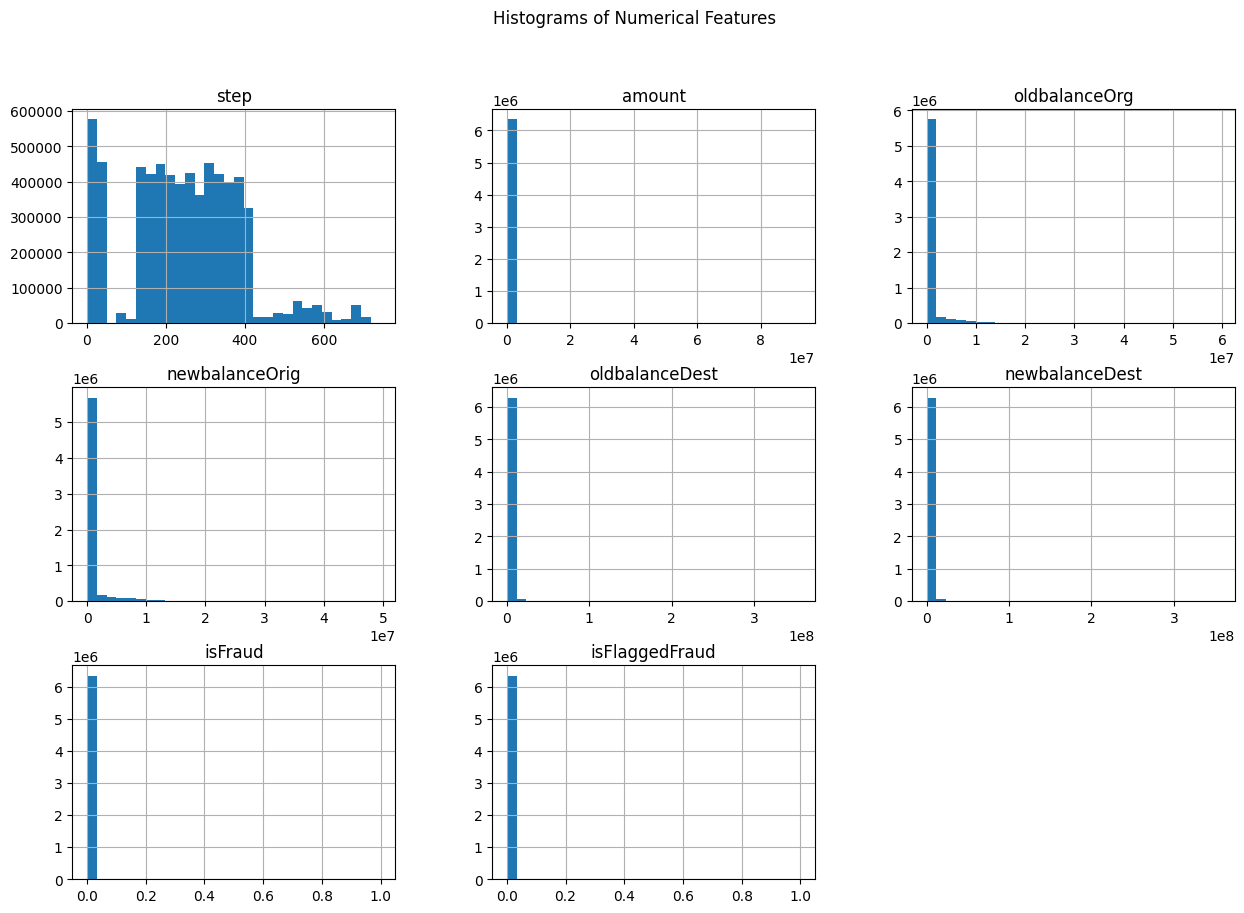

In [30]:
data[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

**Correlation Between Features**

In [31]:
# Compute the correlation matrix
correlation_matrix = data.corr()

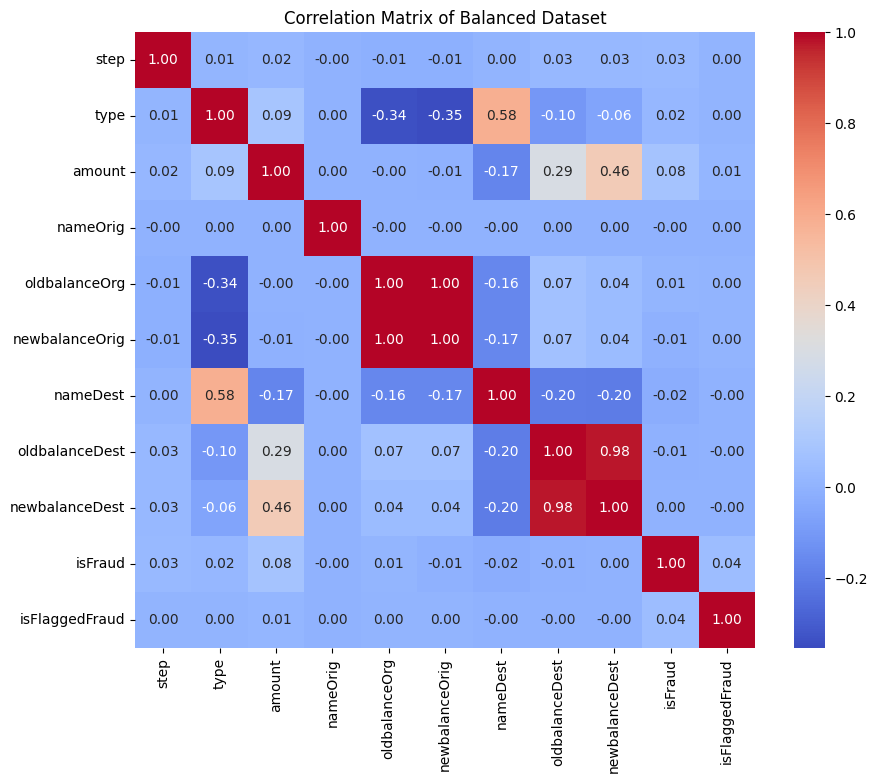

In [32]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Balanced Dataset')
plt.show()

This shows the relationship between fraud transaction & other features.

* It can be seen that nameOrig, newbalanceOrig, oldbalanceDest, nameDest are almost no related with isFraud.
* Similarly, newbalanceOrig, oldbalanceOrig & newbalanceDest, oldbalanceDest are highly related


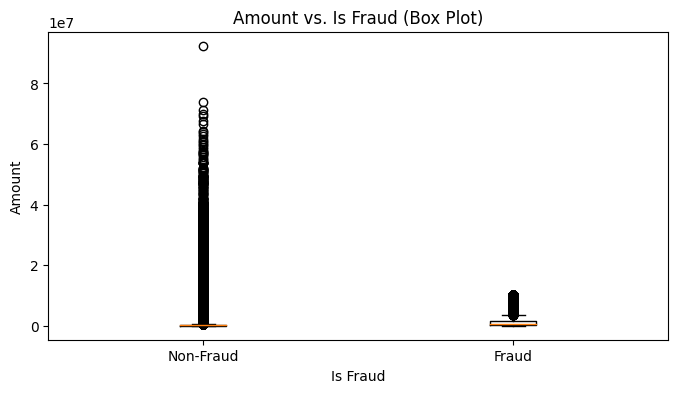

In [33]:
plt.figure(figsize=(8, 4))

# Prepare data for box plot
fraud_data = [data[data['isFraud'] == label]['amount'] for label in [0, 1]]

# Plot
plt.boxplot(fraud_data, labels=['Non-Fraud', 'Fraud'])
plt.title('Amount vs. Is Fraud (Box Plot)')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')

plt.show()

#Feature Engineering:

**Drop Irrelvent attributes**

In [34]:
columns_dropped = [ "step","nameOrig", "nameDest", "oldbalanceDest", "newbalanceDest", "isFlaggedFraud"]
reduced_data = data.drop(columns = columns_dropped)
reduced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,3,9839.64,170136.0,160296.36,0
1,3,1864.28,21249.0,19384.72,0
2,4,181.00,181.0,0.00,1
3,1,181.00,181.0,0.00,1
4,3,11668.14,41554.0,29885.86,0


**Add New Feature**

In [35]:
reduced_data['deltabalanceOrig'] = reduced_data['oldbalanceOrg'] - reduced_data['newbalanceOrig']
reduced_data['deltabalanceDest'] = data['newbalanceDest'] - data['oldbalanceDest']

reduced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,deltabalanceOrig,deltabalanceDest
0,3,9839.64,170136.0,160296.36,0,9839.64,0.0
1,3,1864.28,21249.0,19384.72,0,1864.28,0.0
2,4,181.00,181.0,0.00,1,181.00,0.0
3,1,181.00,181.0,0.00,1,181.00,-21182.0
4,3,11668.14,41554.0,29885.86,0,11668.14,0.0


**Scale Numerical Features**

In [36]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
reduced_data[['amount', 'oldbalanceOrg', 'newbalanceOrig','deltabalanceOrig', 'deltabalanceDest']] = scaler.fit_transform(reduced_data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'deltabalanceOrig','deltabalanceDest']])

# Display the scaled features
reduced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,deltabalanceOrig,deltabalanceDest
0,3,-0.281560,-0.229810,-0.237622,0,0.211876,-0.152896
1,3,-0.294767,-0.281359,-0.285812,0,0.157490,-0.152896
2,4,-0.297555,-0.288654,-0.292442,1,0.146011,-0.152896
3,1,-0.297555,-0.288654,-0.292442,1,0.146011,-0.178952
4,3,-0.278532,-0.274329,-0.282221,0,0.224345,-0.152896


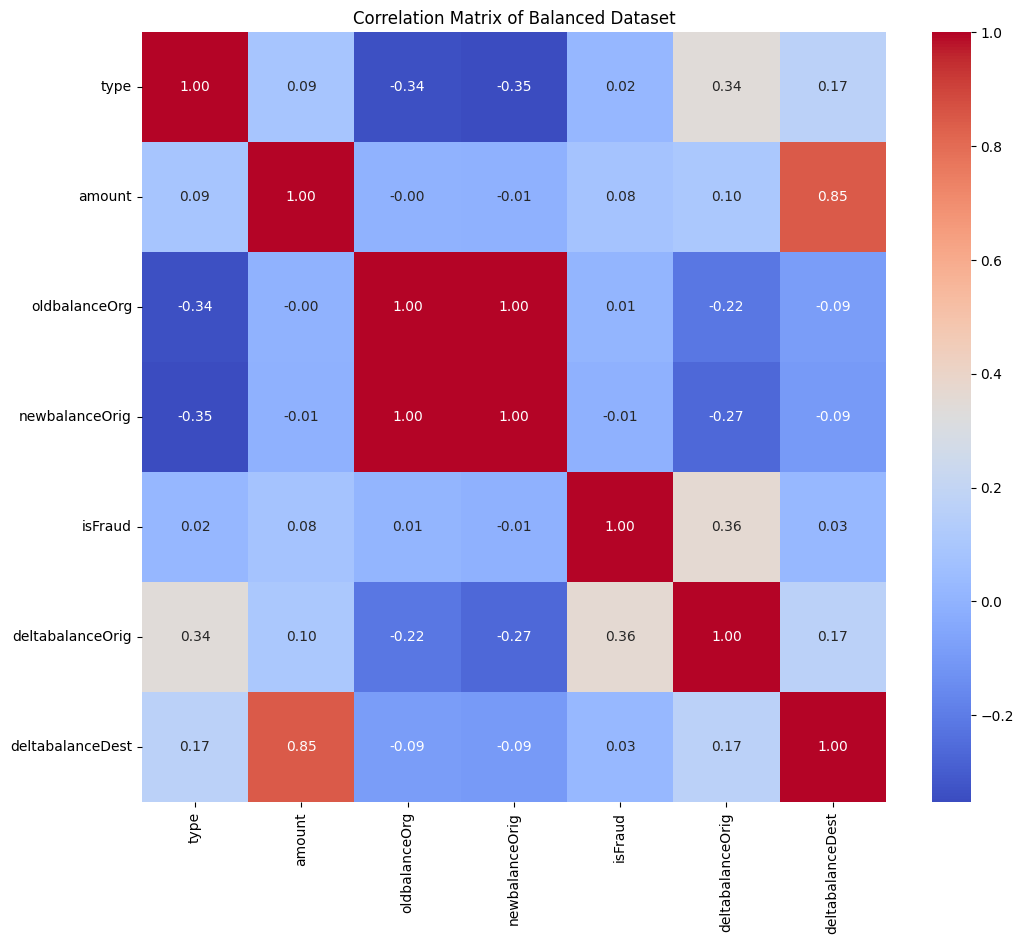

In [37]:
reduced_data.head()
cor = reduced_data.corr()
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Balanced Dataset')
plt.show()

###Balancing of Dataset
  
  Since our dataset is highly unbalanced. Therefore, we need to balance it. There are two ways of balancing the dataset
*   Undersampling
*   Oversampling



#### Under Sampling Dataset

Legit transaction record is significantly larger than fraudulant transaction. We have 8213 fraud transaction record that is enough for training and testing our. Due to computational/memory limit, we have used undersampling technique.

In [38]:
legit = reduced_data[data.isFraud == 0]
fraud = reduced_data[data.isFraud == 1]

Text(0.5, 1.0, 'Distribution of legit & fraudulent transaction')

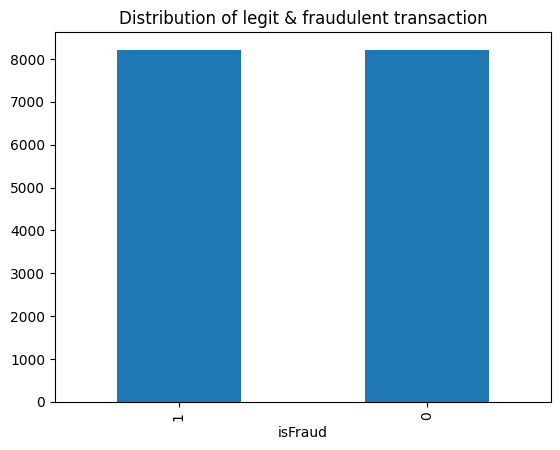

In [39]:
balanced_data = pd.concat([fraud, legit.sample(n=len(fraud), random_state=42)])
balanced_data['isFraud'].value_counts().plot(kind='bar').set_title('Distribution of legit & fraudulent transaction')

In [40]:
balanced_data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud,deltabalanceOrig,deltabalanceDest
2,4,-0.297555,-0.288654,-0.292442,1,0.146011,-0.152896
3,1,-0.297555,-0.288654,-0.292442,1,0.146011,-0.178952
251,4,-0.293208,-0.287745,-0.292442,1,0.163912,-0.152896
252,1,-0.293208,-0.287745,-0.292442,1,0.163912,-0.185127
680,4,-0.264522,-0.281748,-0.292442,1,0.282035,-0.152896


In [41]:
X = balanced_data.drop(columns=['isFraud'], axis=1)
y = balanced_data['isFraud']
X.head()

,type,amount,oldbalanceOrg,newbalanceOrig,deltabalanceOrig,deltabalanceDest
2,4,-0.297555,-0.288654,-0.292442,0.146011,-0.152896
3,1,-0.297555,-0.288654,-0.292442,0.146011,-0.178952
251,4,-0.293208,-0.287745,-0.292442,0.163912,-0.152896
252,1,-0.293208,-0.287745,-0.292442,0.163912,-0.185127
680,4,-0.264522,-0.281748,-0.292442,0.282035,-0.152896


#Model Building:

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Decision Tree

**Pre-Built Sklearn Model**

In [59]:
dt_p = DecisionTreeClassifier(random_state=42)
dt_p.fit(X_train, y_train)

# Predict on the test set
y_pred_p_dt = dt_p.predict(X_test)

In [61]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_p_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p_dt))

Accuracy: 0.9890444309190505
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1616   21]
 [  15 1634]]


**Self-Built Model**

In [65]:
X_train_n = X_train.to_numpy()
X_test_n = X_test.to_numpy()
y_train_n = y_train.to_numpy()
y_test_n = y_test.to_numpy()

In [66]:
# Initialize and train the decision tree
dt_s = DecisionTreeClassifierScratch()
dt_s.fit(X_train_n, y_train_n)
y_pred_s_dt = dt_s.predict(X_test_n)

In [68]:
# Evaluation
print("Accuracy:", accuracy_score(y_test_n, y_pred_s_dt))
print("Classification Report:\n", classification_report(y_test_n, y_pred_s_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test_n, y_pred_s_dt))

Accuracy: 0.9911746804625685
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1620   17]
 [  12 1637]]


### 2. K-Nearest Kneighbor






**Pre-Built Model**

In [94]:
# Train a K-Nearest Neighbors model
knn_p = KNeighborsClassifier(n_neighbors=1)
knn_p.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [95]:
# Predict on the test set
y_pred_p_knn = knn_p.predict(X_test)

In [96]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_p_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p_knn))

Accuracy: 0.9881314668289713
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1613   24]
 [  15 1634]]


**Self-Built Model**

In [97]:
knn = KNNScratchNew(k=1)
knn.fit(X_train_n, y_train_n)

y_pred_s_knn = knn.predict(X_test_n)

In [98]:
# Evaluation
print("Accuracy:", accuracy_score(y_test_n, y_pred_s_knn))
print("Classification Report:\n", classification_report(y_test_n, y_pred_s_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test_n, y_pred_s_knn))

Accuracy: 0.9881314668289713
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1613   24]
 [  15 1634]]


###3. Logistic Regression

**Pre-Built Model**

In [103]:
# Initialize and train the logistic regression model
lr_p = LogisticRegression()
lr_p.fit(X_train, y_train)

LogisticRegression()

In [104]:
#predict
y_pred_p_lr = lr_p.predict(X_test)

In [105]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_p_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p_lr))

Accuracy: 0.9056603773584906
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1637
           1       0.95      0.86      0.90      1649

    accuracy                           0.91      3286
   macro avg       0.91      0.91      0.91      3286
weighted avg       0.91      0.91      0.91      3286

Confusion Matrix:
 [[1563   74]
 [ 236 1413]]


**Self-Built Model**

In [112]:
lr_s = Logistic_Regression_scratch()
lr_s.fit(X_train_n, y_train_n)
y_pred_s_lr = lr_s.predict(X_test_n)

In [113]:
print("Accuracy:", accuracy_score(y_test_n, y_pred_s_lr))
print("Classification Report:\n", classification_report(y_test_n, y_pred_s_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test_n, y_pred_s_lr))

Accuracy: 0.8962264150943396
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1637
           1       0.95      0.84      0.89      1649

    accuracy                           0.90      3286
   macro avg       0.90      0.90      0.90      3286
weighted avg       0.90      0.90      0.90      3286

Confusion Matrix:
 [[1564   73]
 [ 268 1381]]


### 4. Random Forest

**Pre-Built Model**

In [114]:
rf_p = RandomForestClassifier(n_estimators=100, random_state=42)
rf_p.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [116]:
y_pred_p_rf = rf_p.predict(X_test)

In [117]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_p_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_p_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_p_rf))

Accuracy: 0.9923919659160073
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1622   15]
 [  10 1639]]


**Self-Built Model**

In [ ]:
# call train test here. But do not write the whole program here instead write self model class at the top of file.

In [118]:
# Train the Random Forest model
rf_s = RandomForestScratch(n_estimators=100, max_depth=10, max_features='sqrt')
rf_s.fit(X_train_n, y_train_n)

Training tree 1/100
Tree 1 trained
Training tree 2/100
Tree 2 trained
Training tree 3/100
Tree 3 trained
Training tree 4/100
Tree 4 trained
Training tree 5/100
Tree 5 trained
Training tree 6/100
Tree 6 trained
Training tree 7/100
Tree 7 trained
Training tree 8/100
Tree 8 trained
Training tree 9/100
Tree 9 trained
Training tree 10/100
Tree 10 trained
Training tree 11/100
Tree 11 trained
Training tree 12/100
Tree 12 trained
Training tree 13/100
Tree 13 trained
Training tree 14/100
Tree 14 trained
Training tree 15/100
Tree 15 trained
Training tree 16/100
Tree 16 trained
Training tree 17/100
Tree 17 trained
Training tree 18/100
Tree 18 trained
Training tree 19/100
Tree 19 trained
Training tree 20/100
Tree 20 trained
Training tree 21/100
Tree 21 trained
Training tree 22/100
Tree 22 trained
Training tree 23/100
Tree 23 trained
Training tree 24/100
Tree 24 trained
Training tree 25/100
Tree 25 trained
Training tree 26/100
Tree 26 trained
Training tree 27/100
Tree 27 trained
Training tree 28/10

In [120]:
# Predict on the test set
y_pred_s_rf = rf_s.predict(X_test_n)

In [121]:
# Evaluation
print("Accuracy:", accuracy_score(y_test_n, y_pred_s_rf))
print("Classification Report:\n", classification_report(y_test_n, y_pred_s_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_n, y_pred_s_rf))

Accuracy: 0.9920876445526476
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1637
           1       0.99      0.99      0.99      1649

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
 [[1622   15]
 [  11 1638]]


#Model Evaluation:

###Decision Tree

#### Sklearn Vs Self-Built Model

In [167]:
models = {
    "Decision Tree Sklearn": dt_p,
    "Decision Tree Self": dt_s
}

In [168]:
# Compare the performance visually using bar plots
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results = {metric: [] for metric in metrics}

In [169]:
report = classification_report(y_test, y_pred_p_dt, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test, y_pred_s_dt))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

report = classification_report(y_test_n, y_pred_s_dt, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test_n, y_pred_s_dt))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])


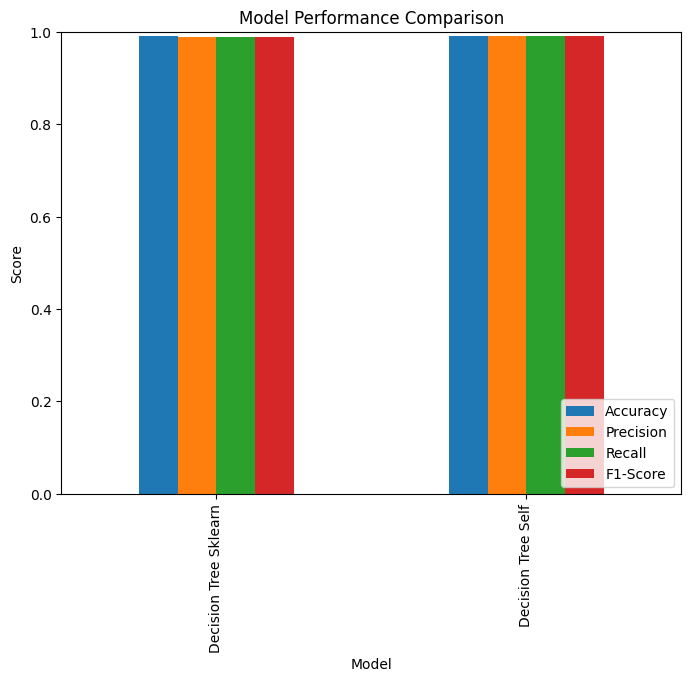

In [170]:
results_df = pd.DataFrame(results, index=models.keys())

# Plot the results
results_df.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

Both algorithms performed almost equal in terms accuracy, precision, recall, F1-score.

But the training time of sklearn is significantly lesser than self built model.

#### Confusion Matix Comparision

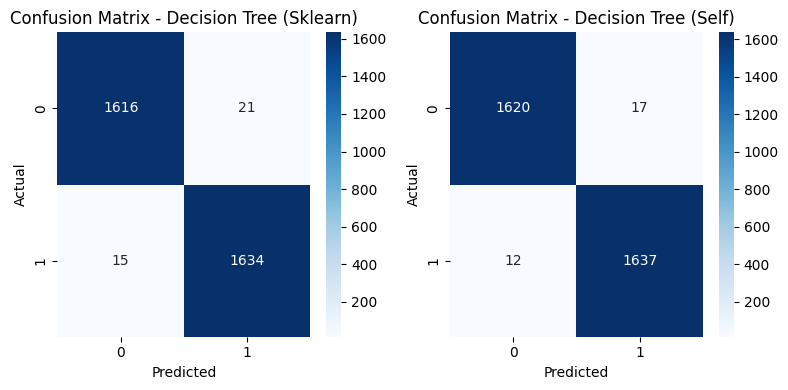

In [171]:

# Compute confusion matrices
cm_dt_s = confusion_matrix(y_test_n, y_pred_s_dt)
cm_dt_p = confusion_matrix(y_test_n, y_pred_p_dt)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(cm_dt_s, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Decision Tree (Self)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_dt_p, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Decision Tree (Sklearn)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [172]:
# Similarly do this comparasion for your models as well

**logistic regression**

In [173]:
models = {
    "logistic regression Sklearn": lr_p,
    "logistic regression Tree Self": lr_s
}

In [174]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results = {metric: [] for metric in metrics}

In [175]:
report = classification_report(y_test, y_pred_p_lr, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test, y_pred_p_lr))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

report = classification_report(y_test_n, y_pred_s_lr, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test_n, y_pred_p_lr))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

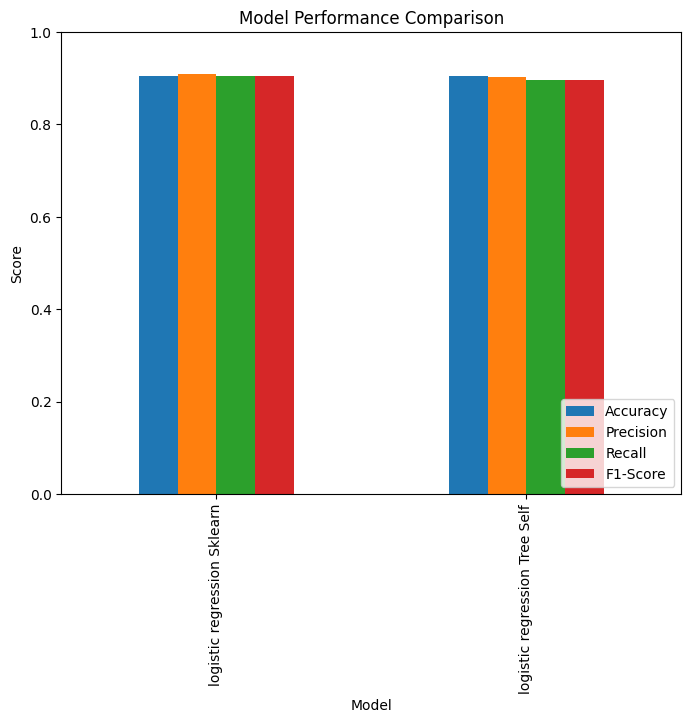

In [176]:
results_df = pd.DataFrame(results, index=models.keys())

# Plot the results
results_df.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

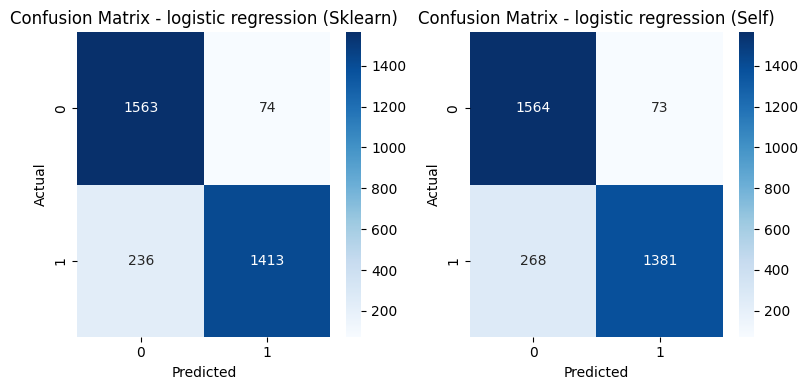

In [177]:
# Compute confusion matrices
cm_lr_s = confusion_matrix(y_test_n, y_pred_s_lr)
cm_lr_p = confusion_matrix(y_test, y_pred_p_lr)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(cm_lr_s, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - logistic regression (Self)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_lr_p, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - logistic regression (Sklearn)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

###k-Nearest Neighbours

#### Sklearn Vs Self-Built Model

In [165]:
models = {
    "1-Nearest Neighbour Sklearn": knn_p,
    "1-Nearest Neighbour Self": knn
}
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results = {metric: [] for metric in metrics}
report = classification_report(y_test, y_pred_p_knn, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test, y_pred_p_knn))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

report = classification_report(y_test_n, y_pred_s_knn, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test_n, y_pred_p_knn))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

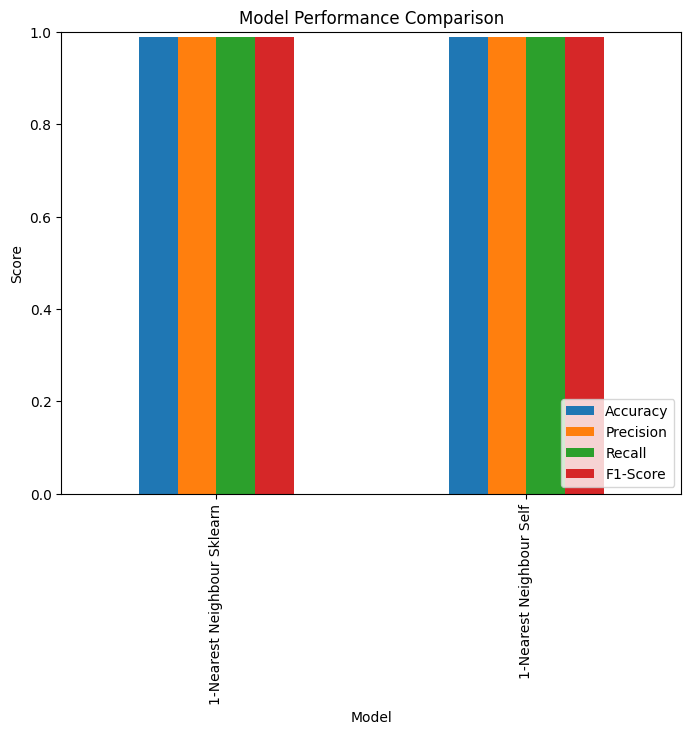

In [166]:
results_df = pd.DataFrame(results, index=models.keys())

# Plot the results
results_df.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

####Confusion Matrix Comparision

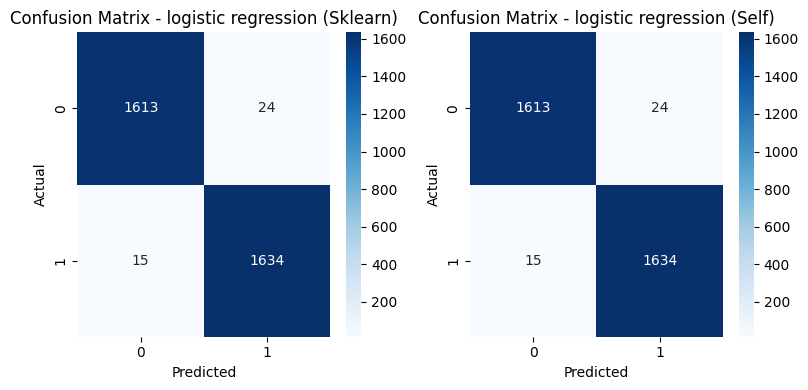

In [155]:
# Compute confusion matrices
cm_knn_s = confusion_matrix(y_test_n, y_pred_s_knn)
cm_knn_p = confusion_matrix(y_test, y_pred_p_knn)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(cm_knn_s, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - logistic regression (Self)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_knn_p, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - logistic regression (Sklearn)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

###Logistic Regression

#### Sklearn Vs Self-Built Model

In [181]:
models = {
    "Logistic Regression (Sklearn)": lr_p,
    "Logistic Regression (Self)": lr_s
}
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results = {metric: [] for metric in metrics}
report = classification_report(y_test, y_pred_p_lr, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test, y_pred_p_lr))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

report = classification_report(y_test_n, y_pred_s_lr, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test_n, y_pred_p_lr))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

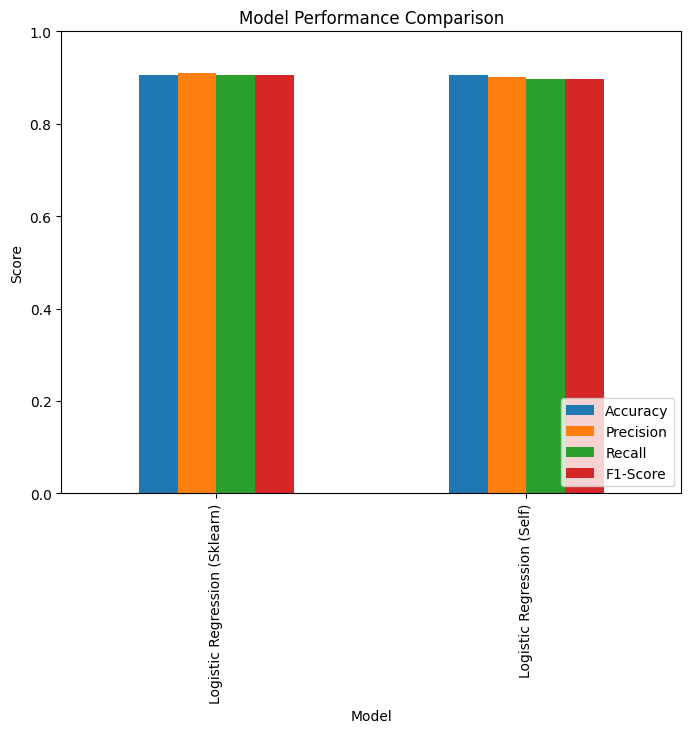

In [182]:
results_df = pd.DataFrame(results, index=models.keys())

# Plot the results
results_df.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

####Confusion Matrix Comparision

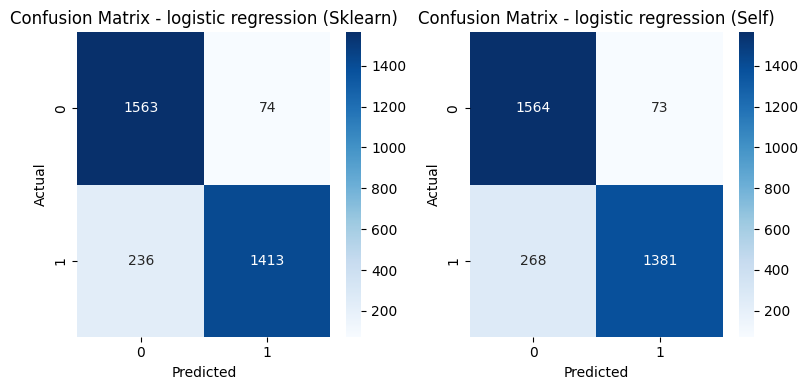

In [183]:
# Compute confusion matrices
cm_lr_s = confusion_matrix(y_test_n, y_pred_s_lr)
cm_lr_p = confusion_matrix(y_test, y_pred_p_lr)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(cm_lr_s, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - logistic regression (Self)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_lr_p, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - logistic regression (Sklearn)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

**Model Evaluation**
In our machine learning project, we evaluated the performance of four different models: K-Nearest Neighbors (KNN), Logistic Regression, Decision Tree, and Random Forest. We considered various metrics such as accuracy, precision, F1 score, and computational efficiency to compare these models.

**Decision Tree**
The Decision Tree model demonstrated a strong balance across multiple metrics, including accuracy, precision, and F1 score. Importantly, it also excelled in terms of computational efficiency. Given its relatively fast training and prediction times, the Decision Tree is considered favorable choice when time efficiency is a critical factor.

**Random Forest**
The Random Forest model achieved higher precision and F1 scores compared to the other models. However, it is computationally intensive and has significantly longer training and prediction times. If time efficiency is not a primary concern, Random Forest stands out as the best-performing model due to its superior accuracy and robust performance across different metrics.

**K-Nearest Neighbors (KNN)**
The KNN model, characterized as a lazy learner, provided good accuracy. However, its need to learn the dataset each time it makes a prediction leads to longer prediction times. Given these time constraints, KNN is less favorable compared to the Decision Tree for this dataset.

**Logistic Regression**
The Logistic Regression model exhibited slightly lower accuracy relative to the other models. While it is computationally efficient, its performance metrics do not match those of the Decision Tree or Random Forest, making it a less suitable choice for this particular dataset.

**Conclusion**
Considering all factors, the Decision Tree model is the most balanced and efficient choice, particularly when time is a significant constraint. For scenarios where computational time is less critical, the Random Forest model would be preferred due to its higher precision and F1 scores. KNN and Logistic Regression, while competent, do not offer the same level of overall performance and efficiency for this dataset.

**SUMMARY**
Our analysis of four different machine learning models—K-Nearest Neighbors (KNN), Logistic Regression, Decision Tree, and Random Forest—revealed key insights into their performance and suitability for our dataset. The Decision Tree model emerged as the most balanced choice, offering a good trade-off between accuracy, precision, and computational efficiency. Random Forest, while achieving the highest precision and F1 scores, was hindered by its intensive computational requirements. KNN provided satisfactory accuracy but was less efficient due to its lazy learning nature. Logistic Regression, despite being computationally efficient, did not perform as well in terms of accuracy.

**Limitations**
Our evaluation was subject to several limitations:

**Computational Resources:** We faced constraints in terms of available computational power and RAM. This significantly impacted our ability to handle the large dataset efficiently.

**Time Constraints:** Training models on the entire dataset required substantial time, which was not feasible given our limitations.

To address these challenges, we opted to undersample our dataset. This approach reduced the time and computational resources required for training, making it more manageable within our constraints. However, undersampling may have affected the overall performance and generalizability of the models.

**Suggestions for Improvement**
Increase Computational Resources: Utilizing more powerful hardware or cloud-based solutions could allow for training on the full dataset, potentially improving model performance.

**Optimize Model Parameters:** Further tuning of hyperparameters for each model could yield better results, especially for complex models like Random Forest.

**Advanced Sampling Techniques:** Instead of undersampling, employing techniques like SMOTE (Synthetic Minority Over-sampling Technique) could help in maintaining a balanced dataset without losing valuable information.

By addressing these limitations and implementing the suggested improvements, we can further enhance the performance and reliability of our machine learning models.

###Random Forest

#### Sklearn Vs Self-Built Model

In [184]:
models = {
    "Random Forest (Sklearn)": rf_p,
    "Random Forest (Self)": rf_s
}
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results = {metric: [] for metric in metrics}
report = classification_report(y_test, y_pred_p_rf, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test, y_pred_p_rf))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

report = classification_report(y_test_n, y_pred_s_rf, output_dict=True)
results["Accuracy"].append(accuracy_score(y_test_n, y_pred_p_rf))
results["Precision"].append(report["weighted avg"]["precision"])
results["Recall"].append(report["weighted avg"]["recall"])
results["F1-Score"].append(report["weighted avg"]["f1-score"])

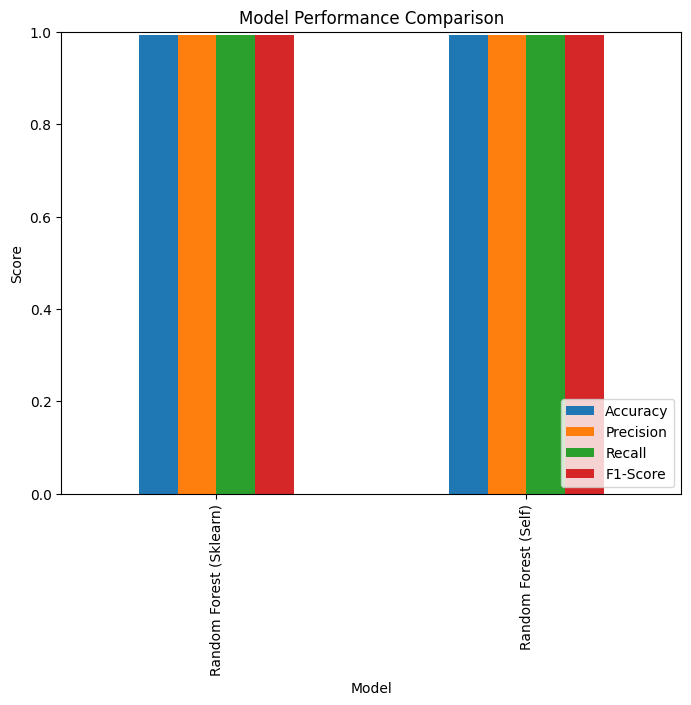

In [185]:
results_df = pd.DataFrame(results, index=models.keys())

# Plot the results
results_df.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

####Confusion Matrix Comparision

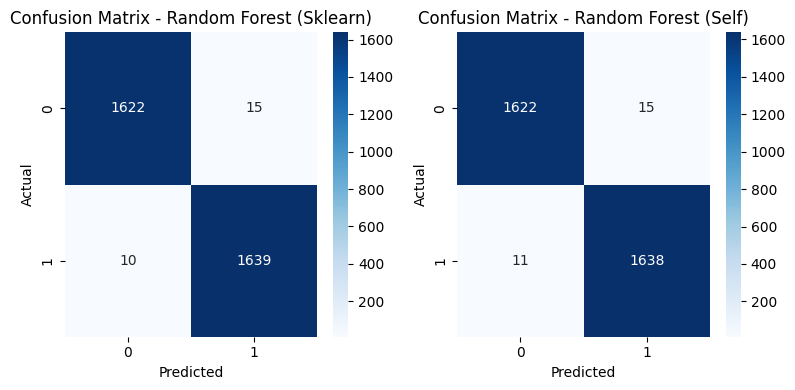

In [186]:
# Compute confusion matrices
cm_rf_s = confusion_matrix(y_test_n, y_pred_s_rf)
cm_rf_p = confusion_matrix(y_test, y_pred_p_rf)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(cm_rf_s, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Random Forest (Self)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_rf_p, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest (Sklearn)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

**Model Evaluation**
In our machine learning project, we evaluated the performance of four different models: K-Nearest Neighbors (KNN), Logistic Regression, Decision Tree, and Random Forest. We considered various metrics such as accuracy, precision, F1 score, and computational efficiency to compare these models.

**Decision Tree**
The Decision Tree model demonstrated a strong balance across multiple metrics, including accuracy, precision, and F1 score. Importantly, it also excelled in terms of computational efficiency. Given its relatively fast training and prediction times, the Decision Tree is considered favorable choice when time efficiency is a critical factor.

**Random Forest**
The Random Forest model achieved higher precision and F1 scores compared to the other models. However, it is computationally intensive and has significantly longer training and prediction times. If time efficiency is not a primary concern, Random Forest stands out as the best-performing model due to its superior accuracy and robust performance across different metrics.

**K-Nearest Neighbors (KNN)**
The KNN model, characterized as a lazy learner, provided good accuracy. However, its need to learn the dataset each time it makes a prediction leads to longer prediction times. Given these time constraints, KNN is less favorable compared to the Decision Tree for this dataset.

**Logistic Regression**
The Logistic Regression model exhibited slightly lower accuracy relative to the other models. While it is computationally efficient, its performance metrics do not match those of the Decision Tree or Random Forest, making it a less suitable choice for this particular dataset.

**Best-performing model**
Considering all factors, the Decision Tree model is the most balanced and efficient choice, particularly when time is a significant constraint. For scenarios where computational time is less critical, the Random Forest model would be preferred due to its higher precision and F1 scores. KNN and Logistic Regression, while competent, do not offer the same level of overall performance and efficiency for this dataset.

#Conclusion:

###Summary



Our analysis of four different machine learning models—K-Nearest Neighbors (KNN), Logistic Regression, Decision Tree, and Random Forest—revealed key insights into their performance and suitability for our dataset. The Decision Tree model emerged as the most balanced choice, offering a good trade-off between accuracy, precision, and computational efficiency. Random Forest, while achieving the highest precision and F1 scores, was hindered by its intensive computational requirements. KNN provided satisfactory accuracy but was less efficient due to its lazy learning nature. Logistic Regression, despite being computationally efficient, did not perform as well in terms of accuracy.





###Limitations



Our evaluation was subject to several limitations:

**Computational Resources:** We faced constraints in terms of available computational power and RAM. This significantly impacted our ability to handle the large dataset efficiently.

**Time Constraints:** Training models on the entire dataset required substantial time, which was not feasible given our limitations.



To address these challenges, we opted to undersample our dataset. This approach reduced the time and computational resources required for training, making it more manageable within our constraints. However, undersampling may have affected the overall performance and generalizability of the models.


###Suggestions for Improvement




Increase Computational Resources: Utilizing more powerful hardware or cloud-based solutions could allow for training on the full dataset, potentially improving model performance.

**Optimize Model Parameters:** Further tuning of hyperparameters for each model could yield better results, especially for complex models like Random Forest.

**Advanced Sampling Techniques:** Instead of undersampling, employing techniques like SMOTE (Synthetic Minority Over-sampling Technique) could help in maintaining a balanced dataset without losing valuable information.



By addressing these limitations and implementing the suggested improvements, we can further enhance the performance and reliability of our machine learning models.